<a href="https://colab.research.google.com/github/pat-olhed/Store_Forecast_TSA/blob/main/store_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Creation



In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')
load_path = "/content/drive/MyDrive/Store_Forecast_TSA/data/df_train_clean.pkl"
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


In [3]:
df_train.head(10)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000
5,2013-01-14,0,24,96995,0.0,0,2013,1,14,0,0.666667
6,2013-01-15,0,24,96995,0.0,0,2013,1,15,1,0.571429
7,2013-01-16,582436,24,96995,1.0,False,2013,1,16,2,0.428571
8,2013-01-17,622071,24,96995,2.0,False,2013,1,17,3,0.714286
9,2013-01-18,0,24,96995,0.0,0,2013,1,18,4,0.714286


In [4]:
# Filter for Dates until March 2014
max_date = '2014-04-01'
df_train = df_train[(df_train['date'] < max_date)]

In [5]:
# Lag features (per store and item)
df_train['lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df_train['lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
df_train['lag_30'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(30)

# Rolling statistics
df_train['rolling_std_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(window=7).std()

df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


df_train.head(10)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,lag_1,lag_7,lag_30,rolling_std_7,is_weekend
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,NaN,NaN,NaN,NaN,0
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000,2.0,NaN,NaN,NaN,0
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667,0.0,NaN,NaN,NaN,0
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,0.0,NaN,NaN,NaN,1
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000,2.0,NaN,NaN,NaN,1
5,2013-01-14,0,24,96995,0.0,0,2013,1,14,0,0.666667,0.0,NaN,NaN,NaN,0
6,2013-01-15,0,24,96995,0.0,0,2013,1,15,1,0.571429,0.0,NaN,NaN,NaN,0
7,2013-01-16,582436,24,96995,1.0,False,2013,1,16,2,0.428571,0.0,2.0,NaN,0.975900,0
8,2013-01-17,622071,24,96995,2.0,False,2013,1,17,3,0.714286,1.0,0.0,NaN,0.786796,0
9,2013-01-18,0,24,96995,0.0,0,2013,1,18,4,0.714286,2.0,0.0,NaN,0.951190,0


In [6]:
split_date = '2014-01-01'
train = df_train[df_train['date'] <= split_date]
test = df_train[df_train['date'] > split_date]

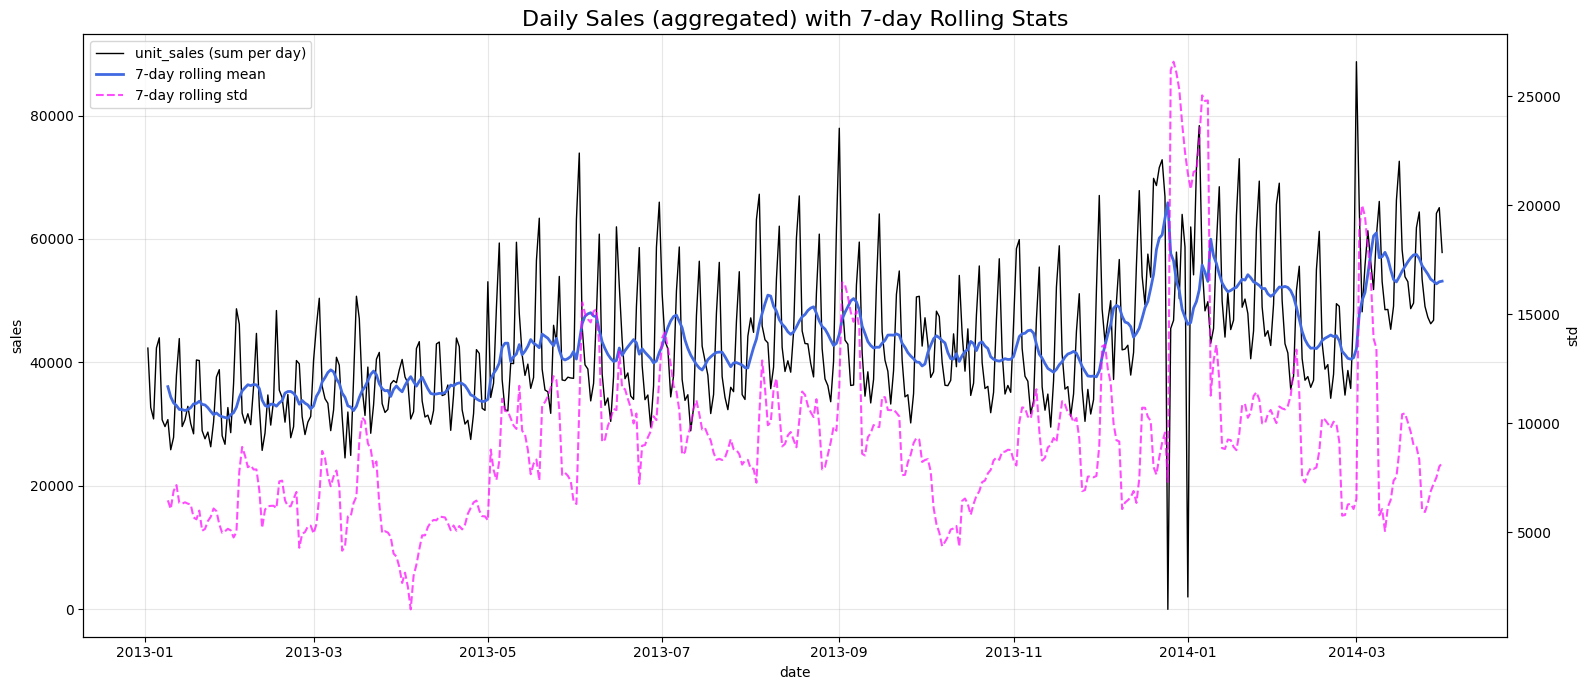

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


df_train['date'] = pd.to_datetime(df_train['date'])


daily = (
    df_train
    .groupby('date')['unit_sales']
    .sum()
    .sort_index()
)

# Rolling-Features
daily_rolling_mean = daily.shift(1).rolling(window=7).mean()
daily_rolling_std  = daily.shift(1).rolling(window=7).std()

# Plot
fig, ax1 = plt.subplots(figsize=(16, 7))

ax1.plot(daily.index, daily, label='unit_sales (sum per day)', color='black', linewidth=1)
ax1.plot(daily.index, daily_rolling_mean, label='7-day rolling mean', color='royalblue', linewidth=2)

# second axis
ax2 = ax1.twinx()
ax2.plot(daily.index, daily_rolling_std, label='7-day rolling std', color='magenta', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.set_title('Daily Sales (aggregated) with 7-day Rolling Stats', fontsize=16)
ax1.set_xlabel('date')
ax1.set_ylabel('sales')
ax2.set_ylabel('std')

lines1, labels1 = ax1.get_lines(), [l.get_label() for l in ax1.get_lines()]
lines2, labels2 = ax2.get_lines(), [l.get_label() for l in ax2.get_lines()]
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
df_train.columns

Index(['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg', 'lag_1',
       'lag_7', 'lag_30', 'rolling_std_7', 'is_weekend'],
      dtype='object')

In [9]:
# Add date-based features
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['month'] = df_train['date'].dt.month

# Train/Test -Split

In [10]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

# XGBoost

In [12]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Convert 'onpromotion' column to boolean dtype
X_train['onpromotion'] = X_train['onpromotion'].astype(bool)
X_test['onpromotion'] = X_test['onpromotion'].astype(bool)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

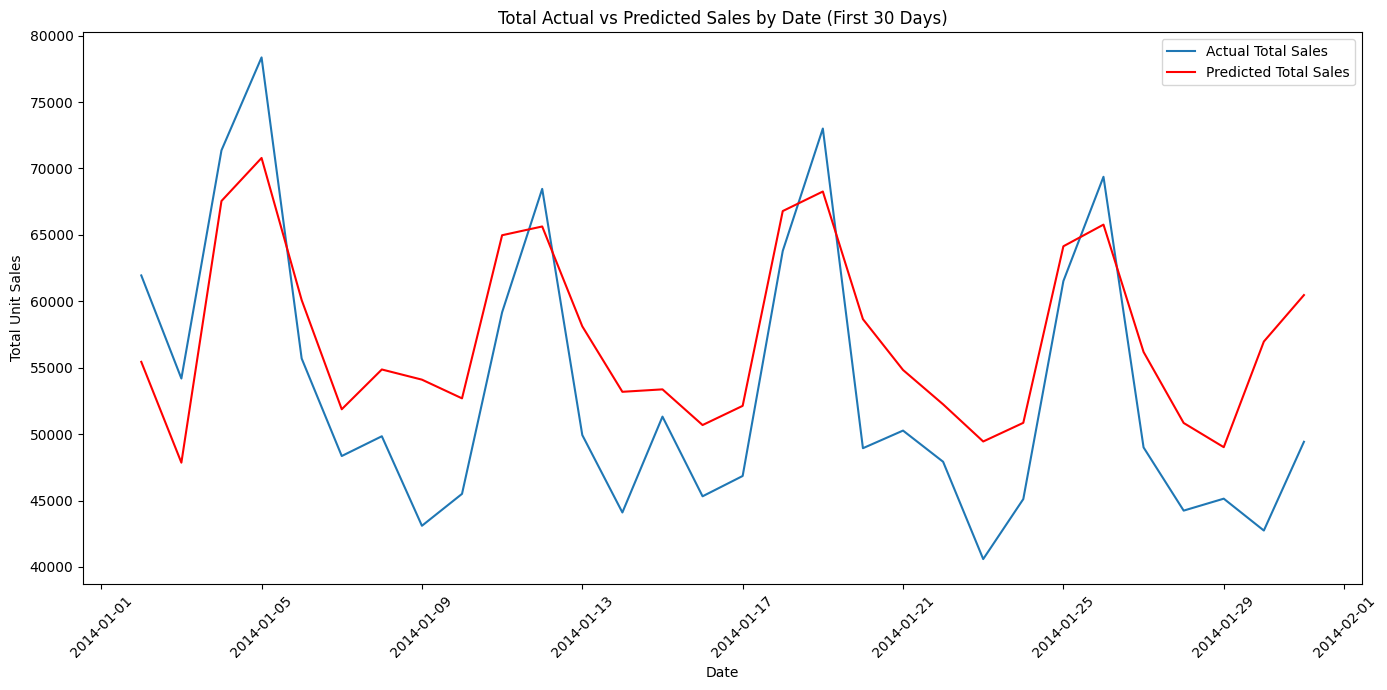

In [16]:
# Plot the actual vs predicted values

test_with_date = test.copy()
test_with_date['y_pred'] = y_pred
test_with_date['y_actual'] = y_test.values

# Convert date column to datetime if needed
test_with_date['date'] = pd.to_datetime(test_with_date['date'])

# Group by date and aggregate
plot_df = test_with_date.groupby('date')[['y_actual', 'y_pred']].sum()

# Plot the first 30 days
plt.figure(figsize=(14, 7))
plt.plot(plot_df.index[:30], plot_df['y_actual'][:30], label='Actual Total Sales')
plt.plot(plot_df.index[:30], plot_df['y_pred'][:30], label='Predicted Total Sales', color='red')
plt.title('Total Actual vs Predicted Sales by Date (First 30 Days)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [18]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'eta': 0.3, 'colsample_bytree': 0.7}


In [19]:
# Best Model

best_model = random_search.best_estimator_

In [20]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Metrics
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

MSE: 43.753368419156814
MAE: 2.099182233758541


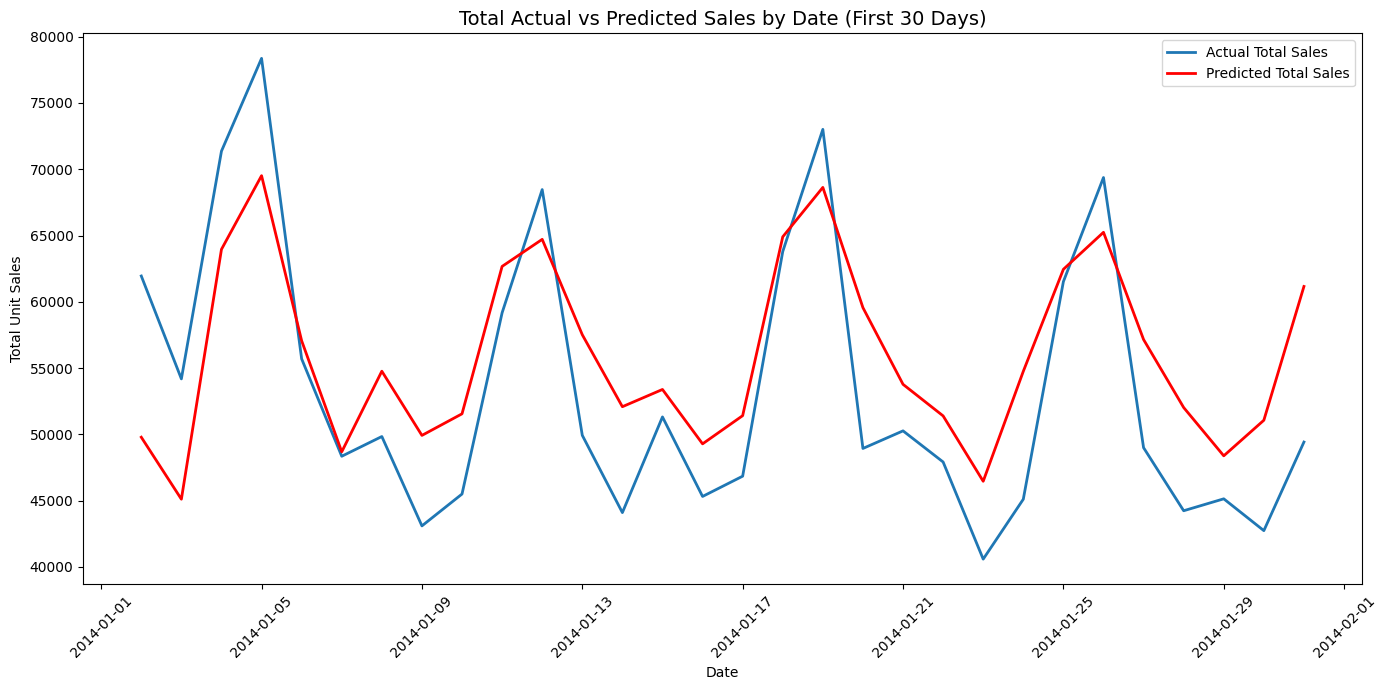

In [22]:
test_with_date = test.copy()

test_with_date['y_pred'] = y_pred
test_with_date['y_actual'] = y_test.values

test_with_date['date'] = pd.to_datetime(test_with_date['date'])

plot_df = (
    test_with_date
    .groupby('date')[['y_actual', 'y_pred']]
    .sum()
    .sort_index()
)


n_days = 30

# Plot
plt.figure(figsize=(14, 7))
plt.plot(plot_df.index[:n_days], plot_df['y_actual'][:n_days],
         label='Actual Total Sales', linewidth=2)
plt.plot(plot_df.index[:n_days], plot_df['y_pred'][:n_days],
         label='Predicted Total Sales', color='red', linewidth=2)

plt.title(f'Total Actual vs Predicted Sales by Date (First {n_days} Days)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
import pickle

# defining a path where we are going to save our model to
path_for_saving = "/content/drive/MyDrive/Store_Forecast_TSA/model/my_model.pkl"

# saving our best model
with open(path_for_saving, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Model saved as pickle file at: {path_for_saving}")

Model saved as pickle file at: /content/drive/MyDrive/Store_Forecast_TSA/model/my_model.pkl
